# PyTorch to ONNX Conversion

This notebook demonstrates how to convert a PyTorch model to ONNX format.

In [1]:
import torch
import torch.nn as nn
import torch.onnx

In [2]:
# Define a more complex neural network model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
model = SimpleNet()

In [3]:
# Create a dummy input tensor (batch_size=1, input_size=10)
dummy_input = torch.randn(1, 10)

# Set the model to evaluation mode
model.eval()

# Export the model to ONNX format
torch.onnx.export(
    model,                          # model being run
    dummy_input,                    # model input (or a tuple for multiple inputs)
    "model.onnx",                   # where to save the model (can be a file or file-like object)
    export_params=True,             # store the trained parameter weights inside the model file
    opset_version=11,               # the ONNX version to export the model to
    do_constant_folding=True,       # whether to execute constant folding for optimization
    input_names=['input'],          # the model's input names
    output_names=['output'],        # the model's output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # variable length axes
)

print("Model exported to model.onnx")

C:\Users\emman\AppData\Local\Temp\ipykernel_172956\1332736854.py:8: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0215 14:59:30.998000 172956 Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `SimpleNet([...]` with `torch.export.export(..., strict=False)`...


C:\Python313\Lib\copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)
The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).


[torch.onnx] Obtain model graph for `SimpleNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "c:\Users\emman\Desktop\PROYECTOS_VS_CODE\GITHUB\Onnx-conversion\venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 120, in call
    converted_proto = _c_api_utils.call_onnx_api(
        func=_partial_convert_version, model=model
    )
  File "c:\Users\emman\Desktop\PROYECTOS_VS_CODE\GITHUB\Onnx-conversion\venv\Lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "c:\Users\emman\Desktop\PROYECTOS_VS_CODE\GITHUB\Onnx-conversion\venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 115, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        proto, target_version=self.target_version
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\

Model exported to model.onnx


In [4]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
ort_session = ort.InferenceSession("model.onnx")

# Prepare input data
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.numpy()}

# Run inference
ort_outs = ort_session.run(None, ort_inputs)

# Compare with PyTorch output
with torch.no_grad():
    torch_out = model(dummy_input)

print("PyTorch output:", torch_out.numpy())
print("ONNX output:", ort_outs[0])
print("Outputs match:", np.allclose(torch_out.numpy(), ort_outs[0], atol=1e-5))

PyTorch output: [[0.2868574]]
ONNX output: [[0.28685737]]
Outputs match: True


W0215 15:11:23.413000 172956 Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
C:\Python313\Lib\copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)
The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).
Failed to convert the model to the target version 11 using the ONNX C API. The model was not mod

[torch.onnx] Obtain model graph for `SimpleNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SimpleNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


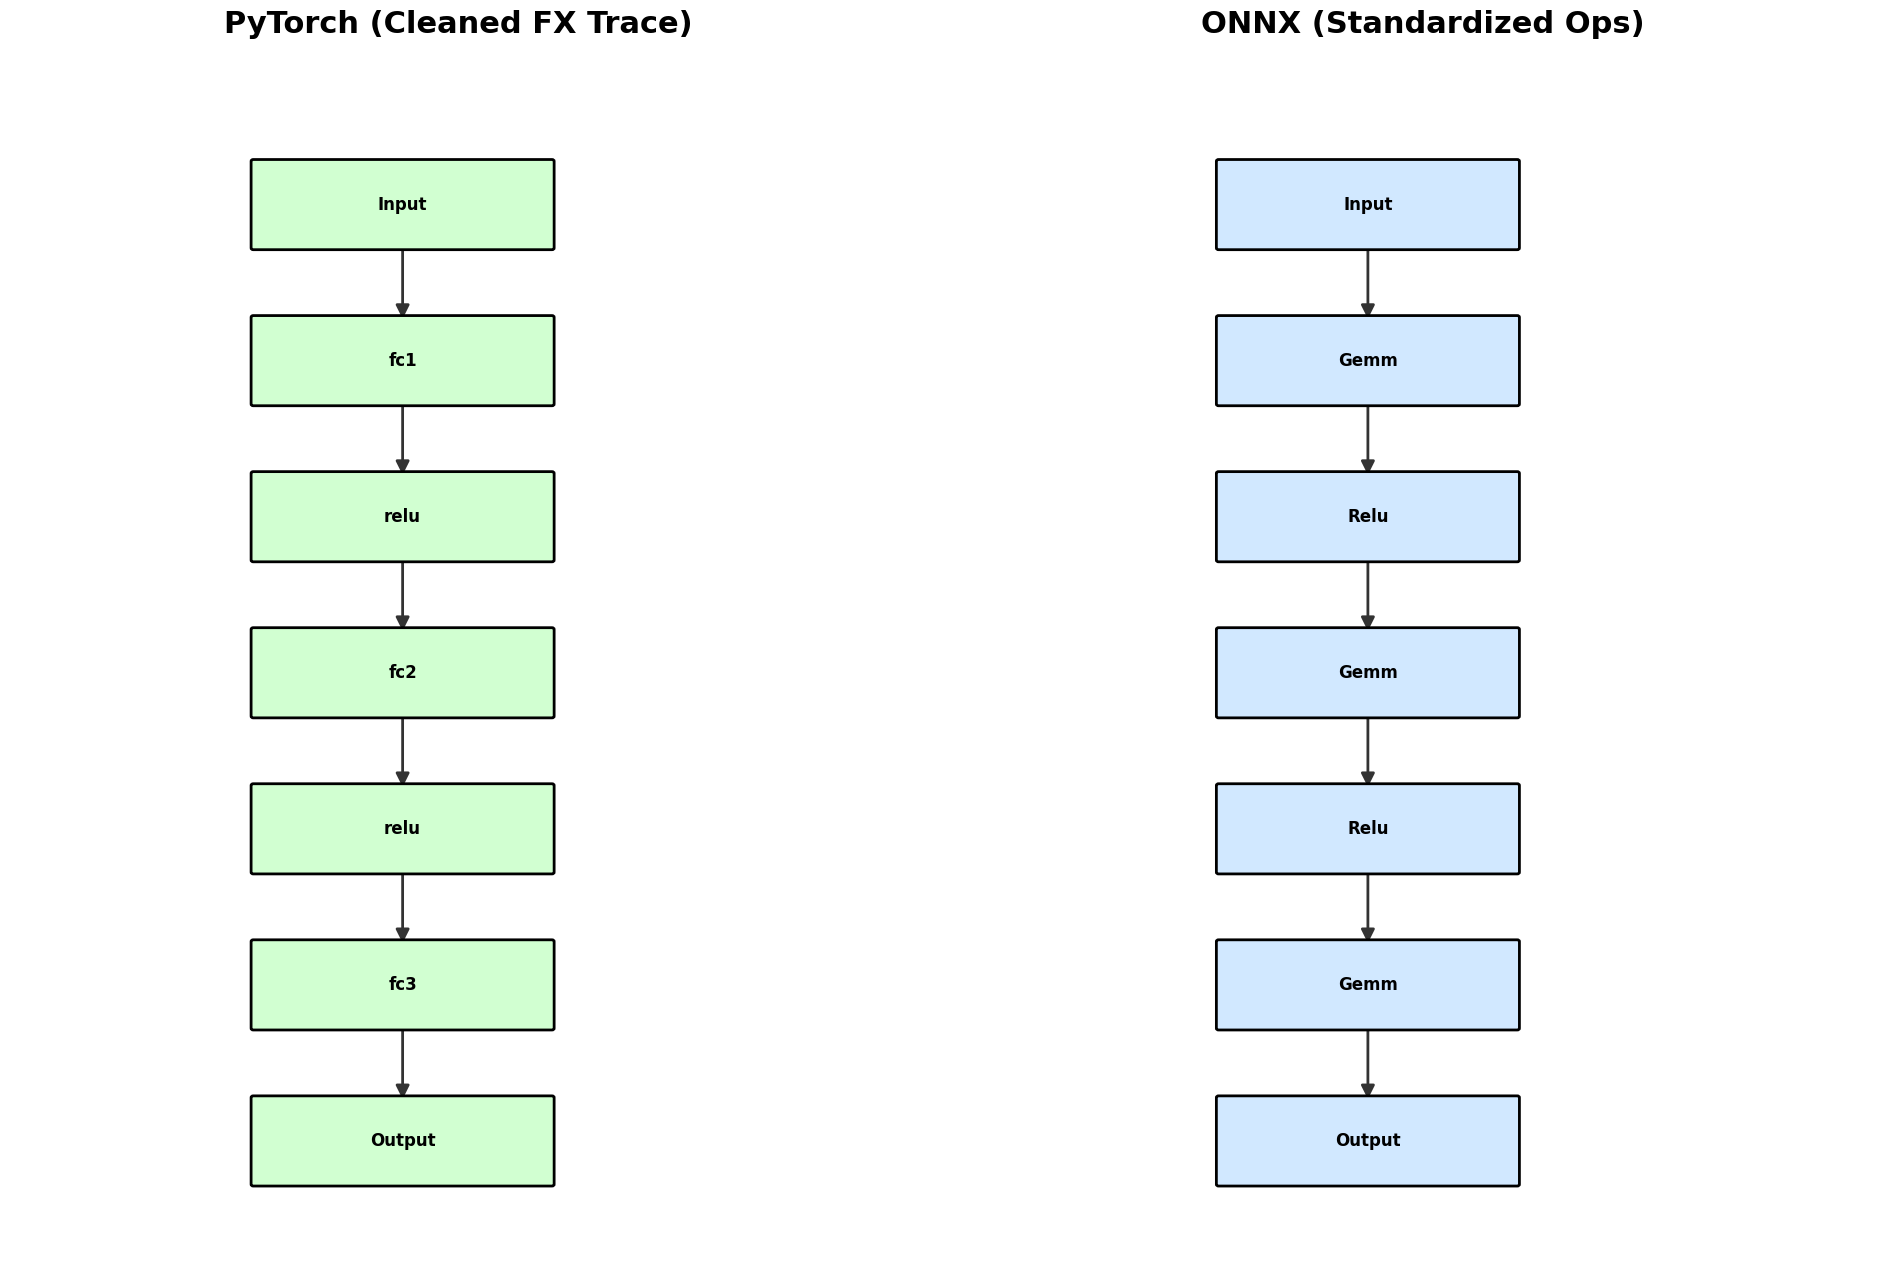

In [17]:
import torch
import torch.nn as nn
import torch.onnx
import torch.fx
import onnx
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Define and Export Model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNet().eval()
dummy_input = torch.randn(1, 10)
torch.onnx.export(model, dummy_input, "model.onnx", opset_version=11,
                  input_names=['input'], output_names=['output'])

# 2. Build Graphs with Clean Labels
def get_graphs():
    # PyTorch FX
    traced = torch.fx.symbolic_trace(model)
    G_p = nx.DiGraph()
    for node in traced.graph.nodes:
        # CLEANING LOGIC: Replace generic ops with specific names
        if node.op == 'placeholder':
            label = "Input"
        elif node.op == 'call_module':
            label = str(node.target)  # Shows 'fc1', 'fc2', etc.
        elif node.op == 'call_function':
            label = node.target.__name__ # Shows 'relu', 'add', etc.
        elif node.op == 'output':
            label = "Output"
        else:
            label = str(node.op)
            
        G_p.add_node(node.name, label=label)
        for arg in node.args:
            if hasattr(arg, 'name'): G_p.add_edge(arg.name, node.name)

    # ONNX
    m_onnx = onnx.load("model.onnx")
    G_o = nx.DiGraph()
    node_outputs = {out: n.name for n in m_onnx.graph.node for out in n.output}
    
    # Add standardized ONNX nodes
    for n in m_onnx.graph.node:
        G_o.add_node(n.name, label=n.op_type)
        for inp in n.input:
            if inp in node_outputs: G_o.add_edge(node_outputs[inp], n.name)
    
    # Explicit Input/Output mapping for ONNX
    for i in m_onnx.graph.input:
        G_o.add_node(f"in_{i.name}", label="Input")
        for n in m_onnx.graph.node:
            if i.name in n.input: G_o.add_edge(f"in_{i.name}", n.name)
            
    for o in m_onnx.graph.output:
        G_o.add_node(f"out_{o.name}", label="Output")
        if o.name in node_outputs: G_o.add_edge(node_outputs[o.name], f"out_{o.name}")
    
    return G_p, G_o

# 3. Plotting Logic with Hierarchical Flow
def draw_side_by_side(G_p, G_o):
    def get_layout(G):
        # Generates a top-down hierarchy
        try:
            generations = list(nx.topological_generations(G))
        except:
            generations = [list(G.nodes())]
            
        pos = {}
        v_spacing = 1.8
        for height, nodes in enumerate(generations):
            for i, node in enumerate(nodes):
                # Center nodes horizontally
                pos[node] = (i - len(nodes)/2, -height * v_spacing)
        return pos, [n for gen in generations for n in gen]

    # Calculate width based on text length
    all_labels = [nx.get_node_attributes(G_p, 'label').get(n, n) for n in G_p.nodes()] + \
                 [nx.get_node_attributes(G_o, 'label').get(n, n) for n in G_o.nodes()]
    u_width = (max(len(str(l)) for l in all_labels) * 0.25) + 1.2

    fig, axs = plt.subplots(1, 2, figsize=(20, 14), facecolor='white')
    config = [(G_p, '#D1FFD1', axs[0], "PyTorch (Cleaned FX Trace)"), 
              (G_o, '#D1E8FF', axs[1], "ONNX (Standardized Ops)")]

    for G, color, ax, title in config:
        pos, order = get_layout(G)
        labels = nx.get_node_attributes(G, 'label')
        
        # Draw Arrows first so they sit behind blocks
        for u, v in G.edges():
            # Calculate start and end points to avoid overlap
            start_y = pos[u][1] - 0.45
            end_y = pos[v][1] + 0.45
            ax.annotate("", xy=(pos[v][0], end_y), xytext=(pos[u][0], start_y),
                        arrowprops=dict(arrowstyle="-|>", lw=2, color='#333333', 
                                      mutation_scale=20), zorder=1)

        # Draw Blocks
        for node in order:
            x, y = pos[node]
            label = labels.get(node, node)
            rect = patches.FancyBboxPatch((x-u_width/2, y-0.5), u_width, 1.0,
                                         boxstyle="round,pad=0.1", mutation_scale=0.2,
                                         lw=2, ec='black', fc=color, zorder=3)
            ax.add_patch(rect)
            ax.text(x, y, label, ha='center', va='center', fontsize=12, fontweight='bold')

        ax.set_title(title, fontsize=22, fontweight='bold', pad=30)
        
        # Adjust limits based on graph size
        y_coords = [p[1] for p in pos.values()]
        ax.set_xlim(-u_width * 1.5, u_width * 1.5)
        ax.set_ylim(min(y_coords)-1.5, max(y_coords)+1.5)
        ax.axis('off')

    plt.tight_layout(pad=5.0)
    plt.savefig("../assets/model_flow.png", dpi=300, bbox_inches='tight')
    plt.show()

# Execution
gp, go = get_graphs()
draw_side_by_side(gp, go)

W0215 15:13:04.622000 172956 Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
C:\Python313\Lib\copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)
The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).
Failed to convert the model to the target version 11 using the ONNX C API. The model was not mod

[torch.onnx] Obtain model graph for `ResidualCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResidualCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 2 of general pattern rewrite rules.


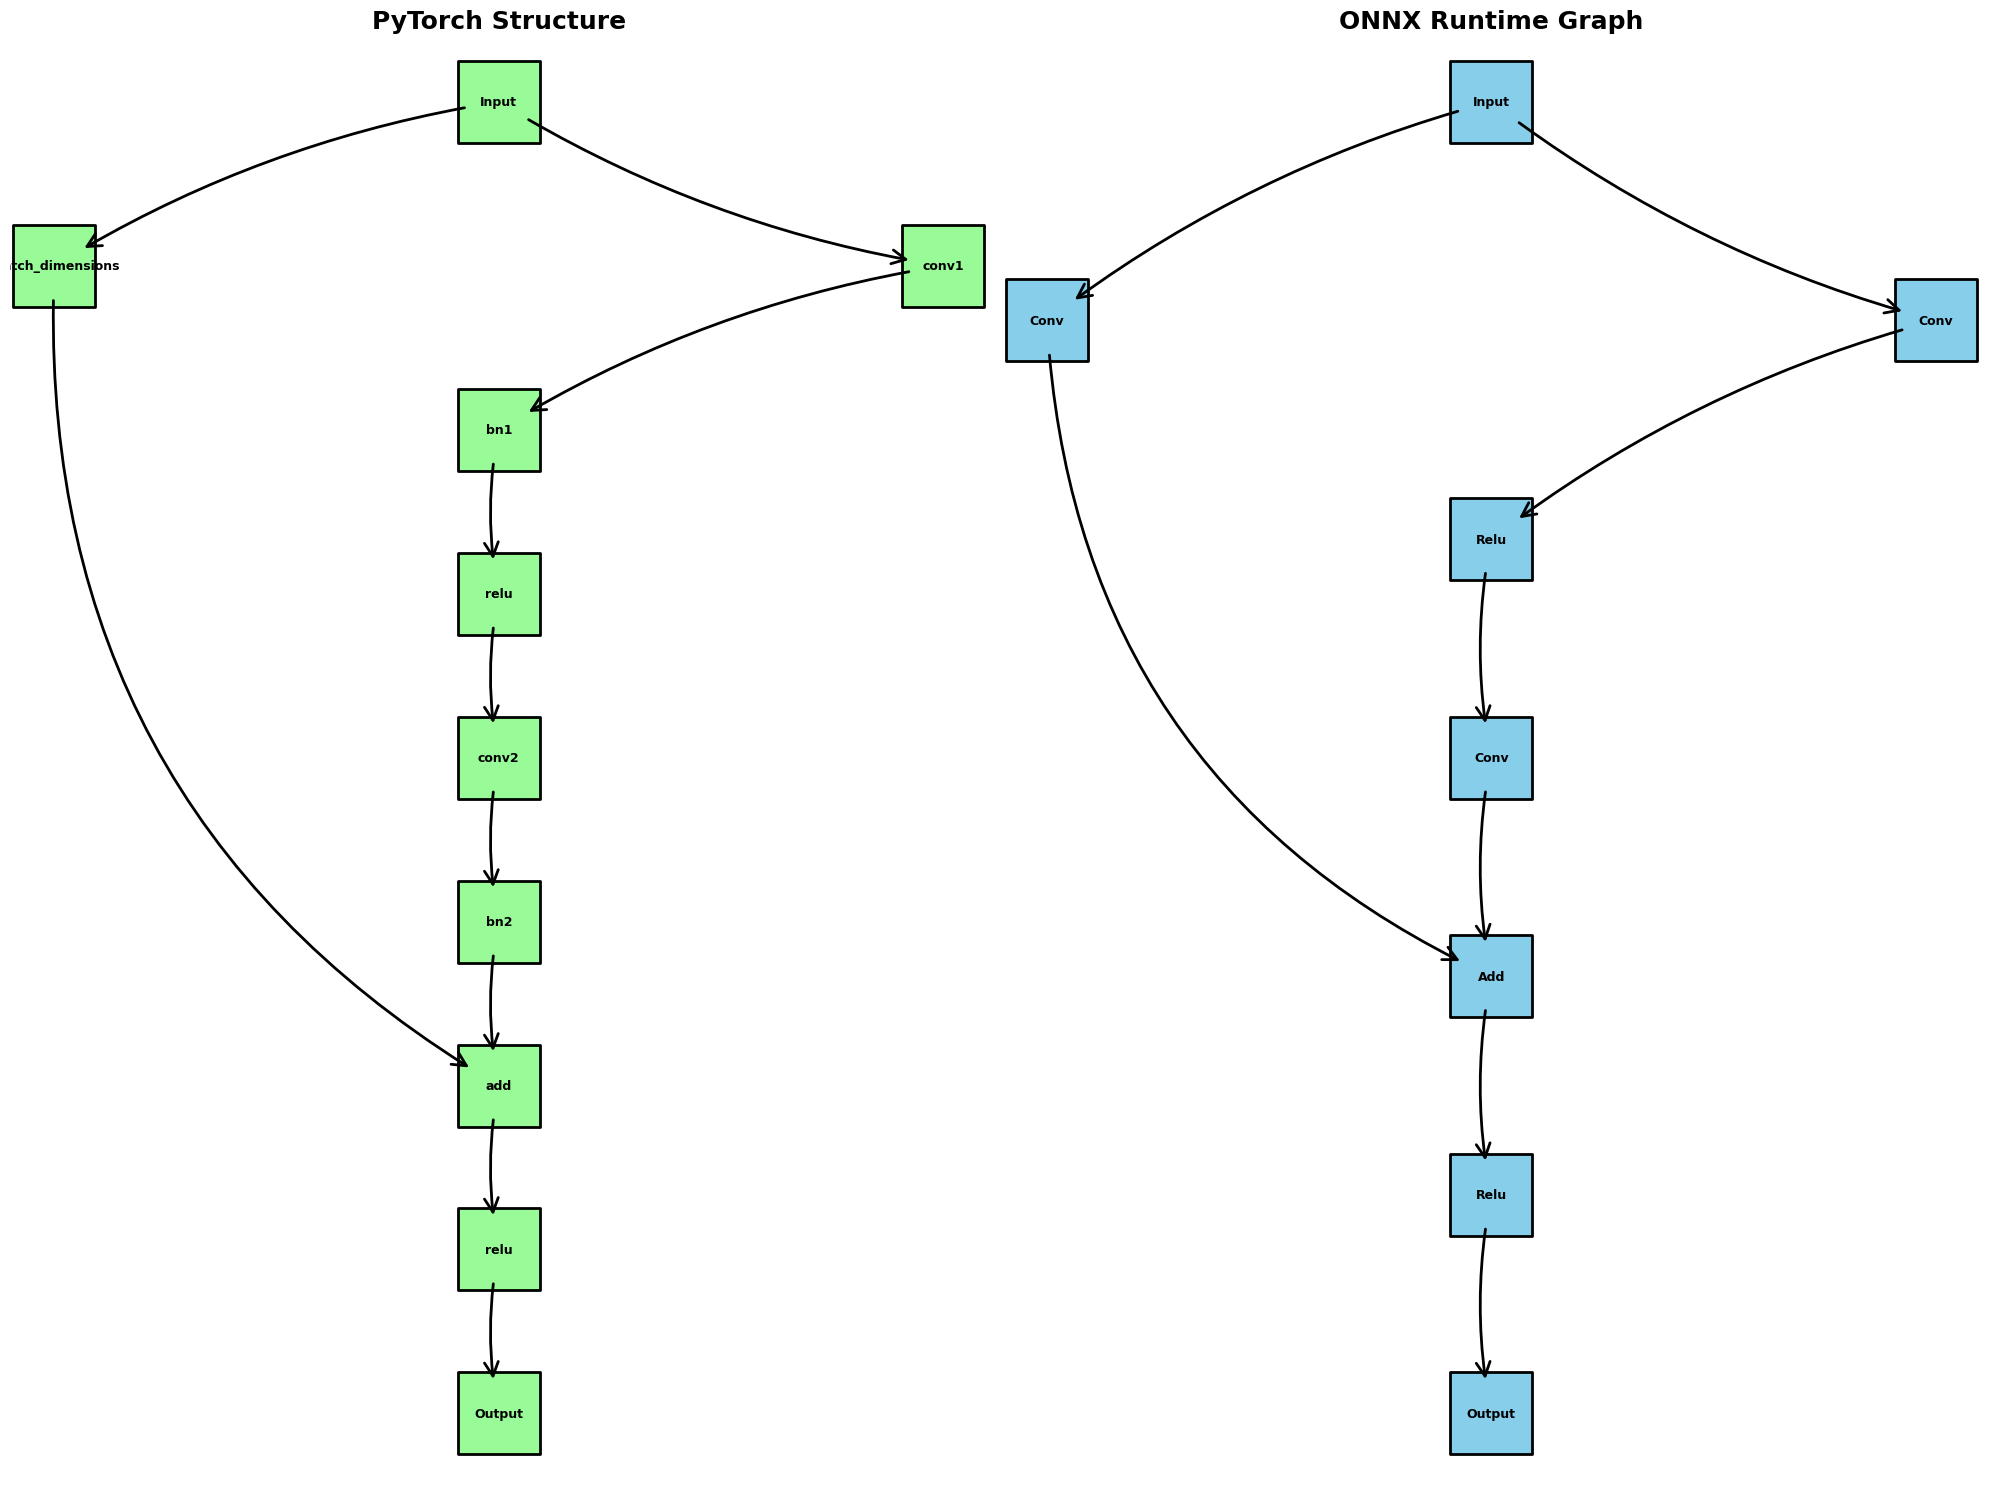

In [18]:
import torch
import torch.nn as nn
import torch.fx
import onnx
import networkx as nx
import matplotlib.pyplot as plt

# 1. Complex Residual Model
class ResidualCNN(nn.Module):
    def __init__(self):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.match_dimensions = nn.Conv2d(3, 16, kernel_size=1)

    def forward(self, x):
        identity = self.match_dimensions(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + identity # Clear 'add' function
        return self.relu(out)

model = ResidualCNN().eval()
dummy_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(model, dummy_input, "complex_model.onnx", opset_version=11)

# 2. Process Graphs with clean labels and manual ranking
def process_graph_data():
    # PyTorch FX
    traced = torch.fx.symbolic_trace(model)
    gp = nx.DiGraph()
    for node in traced.graph.nodes:
        if node.op == 'placeholder': label = "Input"
        elif node.op == 'call_module': label = f"{node.target}"
        elif node.op == 'call_function': label = f"{node.target.__name__ if hasattr(node.target, '__name__') else str(node.target)}"
        elif node.op == 'output': label = "Output"
        else: label = str(node.op)
        gp.add_node(node.name, label=label)
        for arg in node.args:
            if hasattr(arg, 'name'): gp.add_edge(arg.name, node.name)

    # ONNX
    m = onnx.load("complex_model.onnx")
    go = nx.DiGraph()
    node_outputs = {out: n.name for n in m.graph.node for out in n.output}
    for n in m.graph.node:
        go.add_node(n.name, label=n.op_type)
        for inp in n.input:
            if inp in node_outputs: go.add_edge(node_outputs[inp], n.name)
    
    # Manual Input/Output for ONNX
    for i in m.graph.input:
        go.add_node(f"in_{i.name}", label="Input")
        for n in m.graph.node:
            if i.name in n.input: go.add_edge(f"in_{i.name}", n.name)
    for o in m.graph.output:
        go.add_node(f"out_{o.name}", label="Output")
        if o.name in node_outputs: go.add_edge(node_outputs[o.name], f"out_{o.name}")
            
    return gp, go

# 3. Custom Vertical Layout (To avoid overlapping and missing directions)
def get_vertical_pos(G):
    # This manually calculates levels to ensure a top-down flow
    pos = {}
    try:
        levels = list(nx.topological_generations(G))
    except:
        return nx.spring_layout(G)
        
    for l, nodes in enumerate(levels):
        for i, node in enumerate(nodes):
            # X spreads out nodes in the same level, Y is the depth
            pos[node] = (i - len(nodes)/2, -l) 
    return pos

def draw_final(gp, go):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15), facecolor='white')
    
    for G, ax, title, color in [(gp, ax1, "PyTorch Structure", '#98FB98'), 
                                (go, ax2, "ONNX Runtime Graph", '#87CEEB')]:
        pos = get_vertical_pos(G)
        labels = nx.get_node_attributes(G, 'label')
        
        # 1. Draw Nodes
        nx.draw_networkx_nodes(G, pos, ax=ax, node_shape='s', 
                               node_size=3500, node_color=color, 
                               edgecolors='black', linewidths=2)
        
        # 2. Draw Labels
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, 
                                font_size=9, font_weight='bold')

        # 3. Draw Edges with visible arrows and curved skip connections
        edges = list(G.edges())
        for u, v in edges:
            # If the edge skips a level, give it more curve
            is_skip = abs(pos[u][1] - pos[v][1]) > 1.5
            rad = 0.3 if is_skip else 0.1
            
            ax.annotate("",
                        xy=pos[v], xycoords='data',
                        xytext=pos[u], textcoords='data',
                        arrowprops=dict(arrowstyle="->", color="black",
                                        shrinkA=25, shrinkB=25,
                                        patchA=None, patchB=None,
                                        connectionstyle=f"arc3,rad={rad}",
                                        mutation_scale=25, # Size of the arrow head
                                        lw=2),
                        )

        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("../assets/complex_model_flow.png", dpi=300, bbox_inches='tight')
    plt.show()

gp, go = process_graph_data()
draw_final(gp, go)